In [4]:
from lib.new_model import *
from lib.utils import *
from lib.alg import *
from lib.vqe import *
from lib.config import *

from math import log2
import numpy as np
import pytest
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import HGate, UGate
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit_aer import AerSimulator
from qiskit.circuit import Gate
from qiskit.circuit import ParameterVector
import random

from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single try of the classical solving of $Sq=\Pi$ and $<D,q>$

In [5]:
n_qubits = 4
S, Pi, mus, sigmas, D, strike_prices, payoff_functions, MC_prices, qp_solution_vector, N, K, norm_Pi= random_payoff_system_from_qubits(n_qubits=n_qubits) # S and Pi are already of size 2^n
i = np.random.randint(1,N+1)
print(f'N={N}, K={K}, i={i}')

     pcost       dcost       gap    pres   dres
 0: -5.0123e+04 -5.0124e+04  2e+01  4e+00  2e-05
 1: -5.0123e+04 -5.0123e+04  4e+00  7e-01  3e-06
 2: -5.0123e+04 -5.0119e+04  3e+00  5e-01  2e-06
 3: -5.0118e+04 -5.0109e+04  4e+00  3e-01  1e-06
 4: -5.0107e+04 -5.0104e+04  2e+00  6e-02  3e-07
 5: -5.0106e+04 -5.0104e+04  2e+00  4e-02  2e-07
 6: -5.0105e+04 -5.0103e+04  2e+00  3e-02  1e-07
 7: -5.0104e+04 -5.0102e+04  2e+00  2e-02  1e-07
 8: -5.0102e+04 -5.0102e+04  2e+00  1e-02  4e-08
 9: -5.0101e+04 -5.0101e+04  5e-01  2e-03  8e-09
10: -5.0101e+04 -5.0101e+04  1e-02  4e-05  2e-10
11: -5.0101e+04 -5.0101e+04  1e-04  4e-07  2e-12
12: -5.0101e+04 -5.0101e+04  1e-06  4e-09  2e-14
Optimal solution found.
N=5, K=10, i=5


In [6]:
print(S)

[[0.         0.         0.         0.         0.         0.43572404
  0.52415619 0.35332138 0.43403343 0.54989449 0.51161236 0.5125773
  0.50919252 0.5437942  0.4736029  0.        ]
 [0.         0.         0.         0.         0.         0.34814853
  0.3605946  0.29216292 0.30351007 0.34868872 0.35569567 0.68177173
  0.28206113 0.45635894 0.54247774 0.        ]
 [0.         0.         0.         0.         0.         0.49375761
  0.65949363 0.32243099 0.2720104  0.99121326 0.43777005 0.34010032
  0.70869251 0.37117512 0.48202658 0.        ]
 [0.         0.         0.         0.         0.         0.88602972
  1.1605854  0.31523992 0.85796017 0.59390737 0.41107731 0.40560117
  0.41702375 0.61657605 0.3821832  0.        ]
 [0.         0.         0.         0.         0.         0.81012785
  0.27347376 1.26996077 0.29125258 0.38369772 0.09878961 0.24035472
  0.34874338 0.11093333 0.75306073 0.        ]
 [0.43572404 0.34814853 0.49375761 0.88602972 0.81012785 0.
  0.         0.         0.

In [7]:
payoff_functions

['put_option', 'call_option', 'put_option', 'call_option', 'call_option']

In [8]:
original_S = extract_original_matrix(S,N,K) # Get S of size (N,K)
original_Pi = Pi[:N]
original_D = extract_original_matrix(D,N,K)

In [9]:
print(f"original S shape : {original_S.shape}") # should be (N,K)
print(f"original D shape : {original_D.shape}") # should be (N,K)
print(f"original Pi shape : {original_Pi.shape}") # should be (N,1)

original S shape : (5, 10)
original D shape : (5, 10)
original Pi shape : (5, 1)


In [13]:
lp_res = solve_lp_problem(D, i, S, Pi)
lp_res

(0.0, 2.49236378757877)

In [14]:
len(qp_solution_vector) - K 

0

In [15]:
original_S 

array([[0.43572404, 0.52415619, 0.35332138, 0.43403343, 0.54989449,
        0.51161236, 0.5125773 , 0.50919252, 0.5437942 , 0.4736029 ],
       [0.34814853, 0.3605946 , 0.29216292, 0.30351007, 0.34868872,
        0.35569567, 0.68177173, 0.28206113, 0.45635894, 0.54247774],
       [0.49375761, 0.65949363, 0.32243099, 0.2720104 , 0.99121326,
        0.43777005, 0.34010032, 0.70869251, 0.37117512, 0.48202658],
       [0.88602972, 1.1605854 , 0.31523992, 0.85796017, 0.59390737,
        0.41107731, 0.40560117, 0.41702375, 0.61657605, 0.3821832 ],
       [0.81012785, 0.27347376, 1.26996077, 0.29125258, 0.38369772,
        0.09878961, 0.24035472, 0.34874338, 0.11093333, 0.75306073]])

In [16]:
original_D / norm_Pi

array([[0.09300846, 0.00457631, 0.17541112, 0.09469907, 0.        ,
        0.01712014, 0.0161552 , 0.01953998, 0.        , 0.0551296 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.27349754, 0.        , 0.04808475, 0.13420355],
       [0.        , 0.        , 0.09038221, 0.14080279, 0.        ,
        0.        , 0.07271287, 0.        , 0.04163808, 0.        ],
       [0.42708407, 0.70163975, 0.        , 0.39901453, 0.13496172,
        0.        , 0.        , 0.        , 0.15763041, 0.        ],
       [0.4813858 , 0.        , 0.94121872, 0.        , 0.05495567,
        0.        , 0.        , 0.02000133, 0.        , 0.42431868]])

In [17]:
print(f"upscaled S shape : {S.shape}") # should be (2^n,2^n)
print(f"upscaled D shape : {D.shape}") # should be (2^n,2^n)
print(f"upscaled Pi shape : {Pi.shape}") # should be (2^n,1)

upscaled S shape : (16, 16)
upscaled D shape : (16, 16)
upscaled Pi shape : (16, 1)


## VQE & Derivative Calculations

### Using the proba vector from the VQE method 

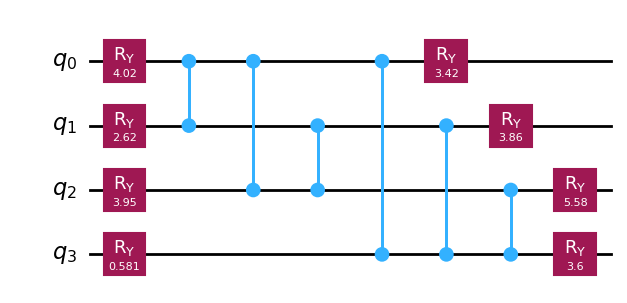

In [18]:
depth = 1
initial_theta = np.random.uniform(0, 2*np.pi, n_qubits * (depth+1) )
variational_circuit = create_variational_circuit(n_qubits, initial_theta,depth=depth)
variational_circuit.decompose().draw(output="mpl")
plt.show()

In [19]:
shotss = calculate_shots(K)
shotss

2303

In [20]:
results = run_vqe(
    n_qubits, S, Pi, D, i, initial_theta, depth, performance_funcs=performance_funcs, cost_funcs=cost_funcs
)

Starting optimization for cost function: vqe_cost_function
Starting optimization for cost function: vqe_sampling_cost_function


In [21]:
history_dict = results["history_dict"]  # Extract the history_dict from results
history_dict

{'vqe_cost_function_cost_history': [0.07429215708990511,
  0.05024515003783492,
  0.02641499329818331,
  0.019387452869377375,
  0.008915971810298018,
  0.0038032025199632447,
  0.0033280665341737237,
  0.00320293520095305,
  0.0031197306040064987,
  0.003098861207154635,
  0.0030739600688017843,
  0.003031049086515969,
  0.0029650793499407246,
  0.0029358600800180046,
  0.0029176536022700317,
  0.0029012443355759254,
  0.00287658937230284,
  0.0028741330859116676,
  0.0028603749822545543,
  0.002854391549209301,
  0.0028510716783873846,
  0.0028500238436360847,
  0.0028484141329151447,
  0.002845823638242373,
  0.00283585179216983,
  0.0028282942989917847,
  0.0028189608433845104,
  0.0028114137410688578,
  0.0028034786924824306,
  0.002795838099841519,
  0.0027911032141345604,
  0.002783359470483582,
  0.002776750880711276,
  0.0027633746863650055,
  0.0027499747342856207,
  0.002743295109309707,
  0.002733645907085691,
  0.002720867841484509,
  0.002707930856623908,
  0.002690835423

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

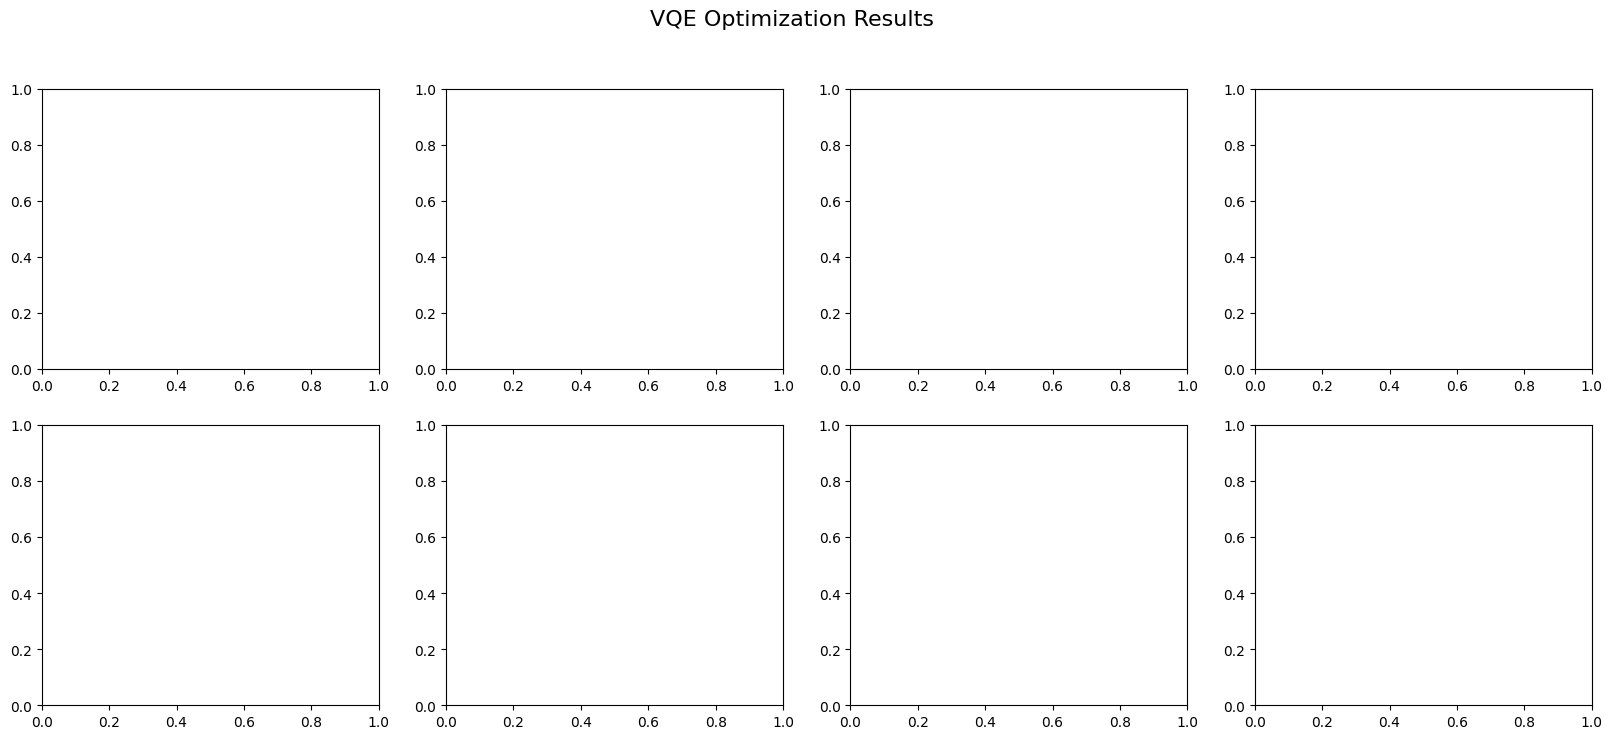

In [22]:
plot_vqe_results(history_dict, cost_funcs, performance_funcs)

7 26


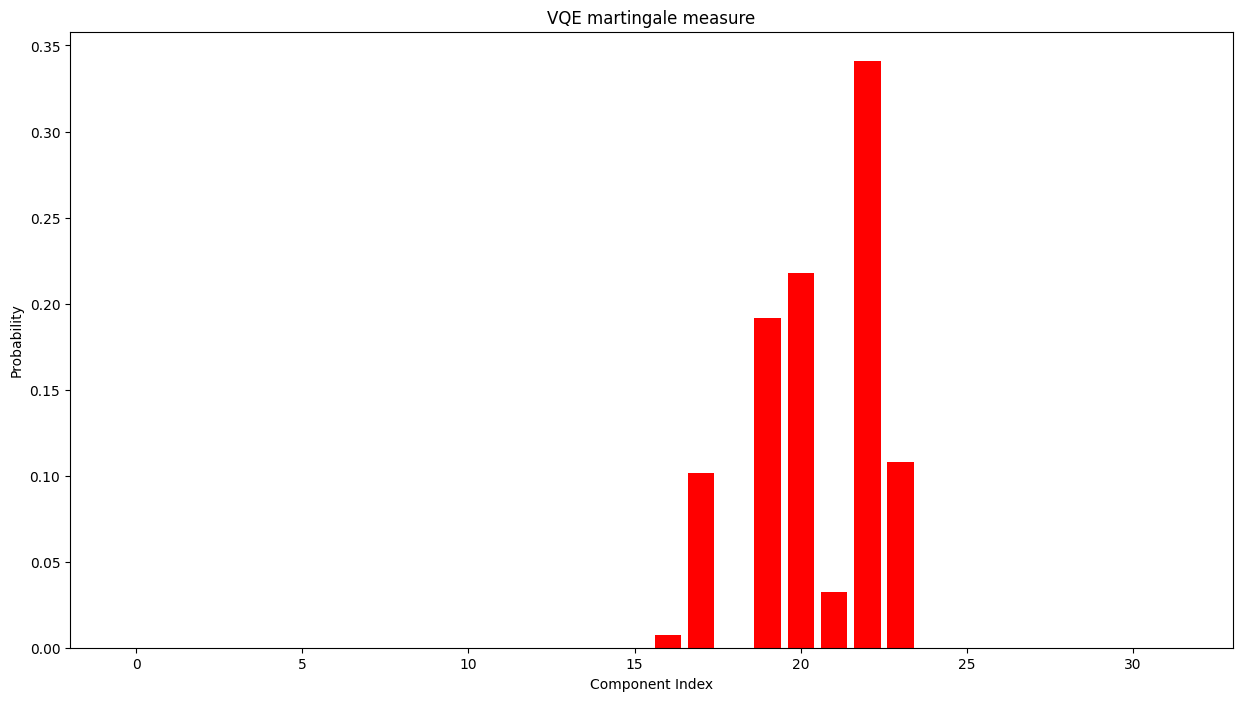

In [ ]:
final_probas_sampled = get_probas(final_ansatzes['vqe_cost_function'])
print(N,N+K)
plt.figure(figsize=(15, 8))

plt.bar(range(len(final_probas_sampled)), final_probas_sampled, color='red')
plt.xlabel('Component Index')
plt.ylabel('Probability')
plt.title('VQE martingale measure')
plt.show()

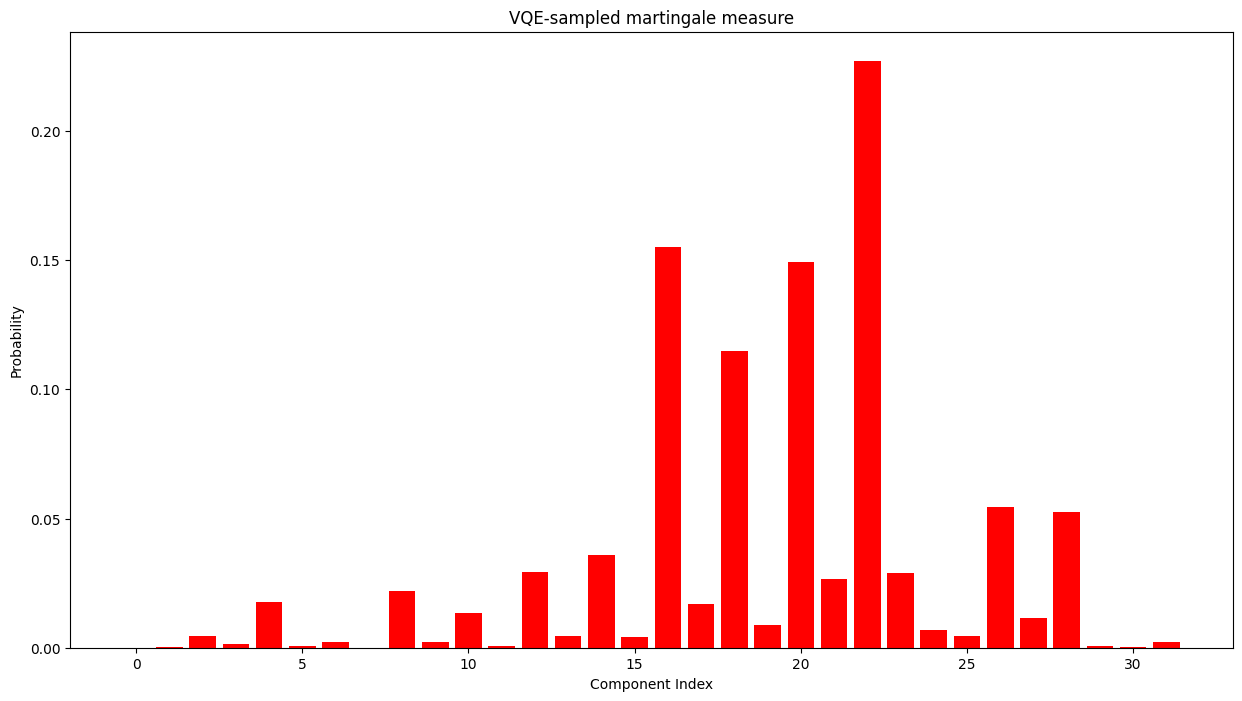

In [ ]:
plt.figure(figsize=(15, 8))
final_probas_th = get_probas(final_ansatzes['vqe_sampling_cost_function'])

plt.bar(range(len(final_probas_th)), final_probas_th, color='red')
plt.xlabel('Component Index')
plt.ylabel('Probability')
plt.title('VQE-sampled martingale measure')
plt.show()

In [ ]:
print(N, N+K-1)

2 28


In [ ]:
# ok

# Comparing all results

The option prices for each asset are calculated by doing $ D \vec{p}(\theta)$

In [ ]:
probas_vector1 = get_probas(final_statevectors["vqe_cost_function"])
probas_vector2 = get_probas(final_statevectors["vqe_sampling_cost_function"])

VQE_option_prices1 = D @ probas_vector1
VQE_option_prices2 = D @ probas_vector2

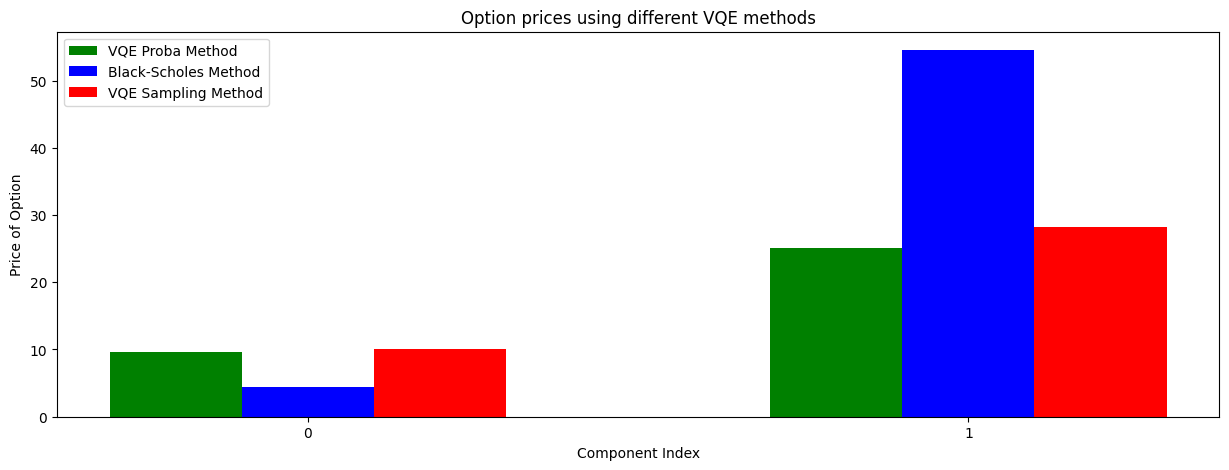

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure all arrays are of the same length as MC_prices
VQE_options_prices1_shortened = VQE_option_prices1[:N]
VQE_options_prices2_shortened = VQE_option_prices2[:N]

MC_prices = MC_prices[:N]

# Generate indices for the bar plot
indices = np.arange(N)
width = 0.2

plt.figure(figsize=(15, 5))

plt.bar(indices - width, VQE_options_prices1_shortened, width, label='VQE Proba Method', color='green')
plt.bar(indices, MC_prices, width, label='Black-Scholes Method', color='blue')
plt.bar(indices + width, VQE_options_prices2_shortened, width, label='VQE Sampling Method', color='red')

plt.xlabel('Component Index')
plt.ylabel('Price of Option')
plt.title('Option prices using different VQE methods')
plt.xticks(indices)
plt.legend()

plt.show()

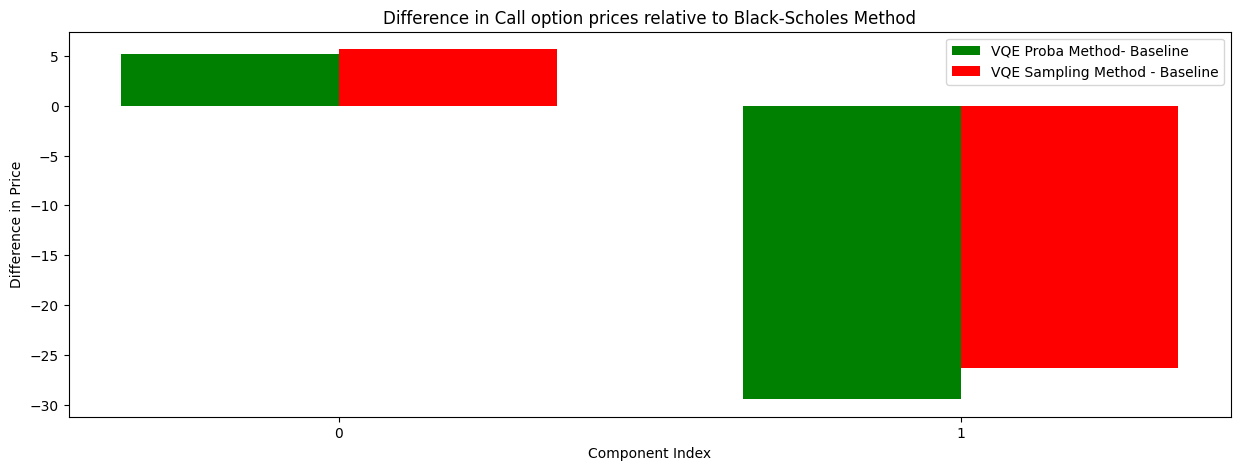

In [ ]:
# Calculate differences
vqe_diff1 = VQE_options_prices1_shortened - MC_prices
vqe_diff2 = VQE_options_prices2_shortened - MC_prices

indices = np.arange(N)
width = 0.35

plt.figure(figsize=(15, 5))

plt.bar(indices - width/2, vqe_diff1, width, label='VQE Proba Method- Baseline', color='green')
plt.bar(indices + width/2, vqe_diff2, width, label='VQE Sampling Method - Baseline', color='red')

plt.xlabel('Component Index')
plt.ylabel('Difference in Price')
plt.title('Difference in Call option prices relative to Black-Scholes Method')
plt.xticks(indices)
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
vqe1_mae = mean_absolute_error(MC_prices, VQE_options_prices1_shortened)
vqe2_mae = mean_absolute_error(MC_prices, VQE_options_prices2_shortened)

# Calculate RMSE
vqe1_rmse = np.sqrt(mean_squared_error(MC_prices, VQE_options_prices1_shortened))
vqe2_rmse = np.sqrt(mean_squared_error(MC_prices, VQE_options_prices2_shortened))

print(f"VQE Proba Method - MAE: {vqe1_mae}, RMSE: {vqe1_rmse}")
print(f"VQE Sampling Method - MAE: {vqe2_mae}, RMSE: {vqe2_rmse}")

VQE Proba Method - MAE: 17.344531519514327, RMSE: 21.155133231607785
VQE Sampling Method - MAE: 16.00166824350036, RMSE: 19.045487074894794


In [ ]:
# OK

# LP Boundaries

In [ ]:
i = np.random.randint(0,N)
i

3

In [ ]:
final_statevectors_lp , history_dict_lp, final_ansatzes_lp, final_thetas_lp = run_vqe(
    n_qubits,
    S,
    Pi,
    D,
    i,
    initial_theta,
    reps,
    optimizer_method="Nelder-Mead",  # Changed from BFGS
    entanglement="full",
    performance_funcs=performance_funcs,
    cost_funcs=lp_boundary_funcs,
)

Starting optimization for cost function: vqe_cost_function_for_dmin
Callback: f_val=81.41454531486833
Callback: f_val=81.41454531486833
Callback: f_val=81.41454531486833
Callback: f_val=71.06022242157829
Callback: f_val=71.06022242157829
Callback: f_val=71.06022242157829
Callback: f_val=56.55161204593191
Callback: f_val=56.55161204593191
Callback: f_val=56.55161204593191
Callback: f_val=56.55161204593191
Callback: f_val=40.95897413642308
Callback: f_val=40.95897413642308
Callback: f_val=40.95897413642308
Callback: f_val=40.95897413642308
Callback: f_val=28.160353090606986
Callback: f_val=28.160353090606986
Callback: f_val=28.160353090606986
Callback: f_val=11.95705172485383
Callback: f_val=11.95705172485383
Callback: f_val=11.95705172485383
Callback: f_val=11.95705172485383
Callback: f_val=11.95705172485383
Callback: f_val=5.4289515472005885
Callback: f_val=5.4289515472005885
Callback: f_val=5.4289515472005885
Callback: f_val=5.4289515472005885
Callback: f_val=2.393049070040828
Callbac

/Users/rubenmaarek/Desktop/Thesis - Quantum Asset Pricing with Variational Methods/variational-martingale-solver/lib/vqe.py:118: RuntimeWarning: Maximum number of iterations has been exceeded.
  


Callback: f_val=78.34201625116428
Callback: f_val=76.3523204612399
Callback: f_val=79.16340164932403
Callback: f_val=71.51714931085392
Callback: f_val=75.63848333043236
Callback: f_val=63.463507834203966
Callback: f_val=60.65536283817401
Callback: f_val=62.32012219659612
Callback: f_val=64.51674514497309
Callback: f_val=58.004317197790805
Callback: f_val=62.182490659268765
Callback: f_val=41.746541014210365
Callback: f_val=41.566723915293494
Callback: f_val=41.06759734128626
Callback: f_val=31.380876601135007
Callback: f_val=29.769162617033146
Callback: f_val=28.00809348096494
Callback: f_val=28.970337142962737
Callback: f_val=14.308329870025
Callback: f_val=13.848343417908898
Callback: f_val=13.9686885286464
Callback: f_val=16.02686687015136
Callback: f_val=15.30667780158775
Callback: f_val=15.279512190107411
Callback: f_val=13.520027245703378
Callback: f_val=14.938449402088866
Callback: f_val=14.484176420106417
Callback: f_val=13.781702428885312
Callback: f_val=13.641227543664991
Cal

/Users/rubenmaarek/Desktop/Thesis - Quantum Asset Pricing with Variational Methods/variational-martingale-solver/lib/vqe.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0][j].set_xlabel("Iteration")


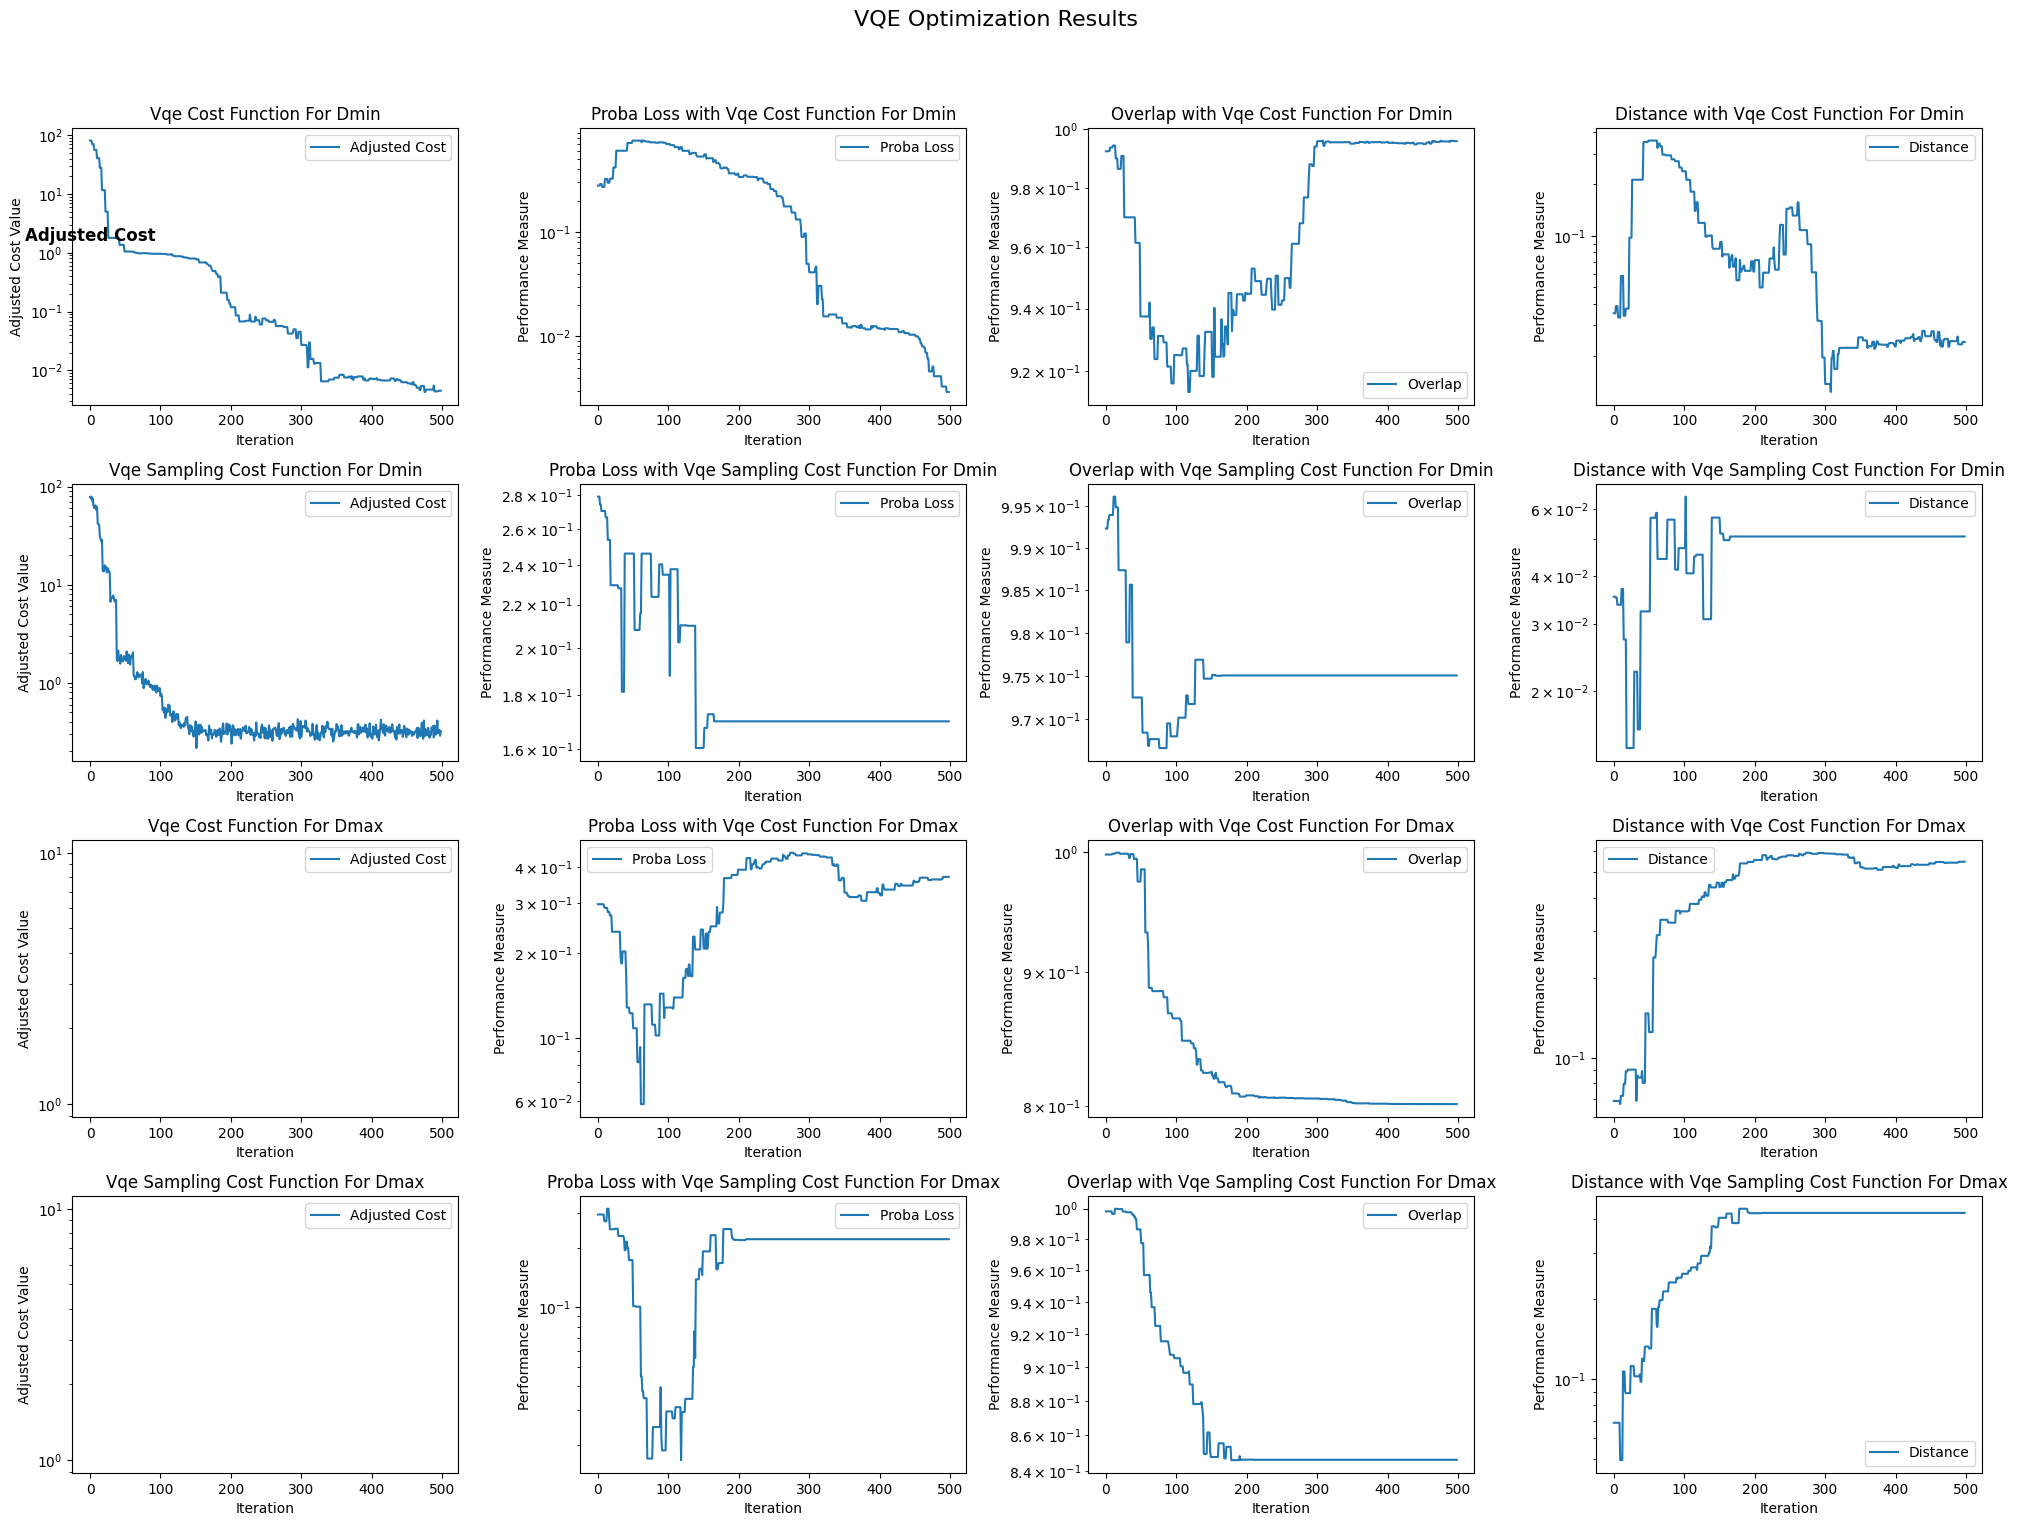

In [ ]:
plot_vqe_results(history_dict_lp, lp_boundary_funcs, performance_funcs)

In [ ]:
probas_vector_lp_min = get_probas(final_statevectors_lp["vqe_cost_function_for_dmin"])
probas_vector_lp_min_sampling = get_probas(final_statevectors_lp["vqe_sampling_cost_function_for_dmin"])

probas_vector_lp_max = get_probas(final_statevectors_lp["vqe_cost_function_for_dmax"])
probas_vector_lp_max_sampling = get_probas(final_statevectors_lp["vqe_sampling_cost_function_for_dmax"])

VQE_option_prices_min = D[i] @ probas_vector_lp_min
VQE_option_prices_min2 = D @ probas_vector_lp_min_sampling

VQE_option_prices_max = D @ probas_vector_lp_max
VQE_option_prices_max2 = D @ probas_vector_lp_max_sampling

NameError: name 'final_statevectors_lp' is not defined

In [ ]:
i_element = i

# Extract d_min and d_max for both normal and sampling
d_min_normal = VQE_option_prices_min[i_element]
d_max_normal = VQE_option_prices_max[i_element]

d_min_sampling = VQE_option_prices_min2[i_element]
d_max_sampling = VQE_option_prices_max2[i_element]

# Extract the i element for comparison from normal and sampling
VQE_price_normal = VQE_option_prices1[i_element]
VQE_price_sampling = VQE_option_prices2[i_element]

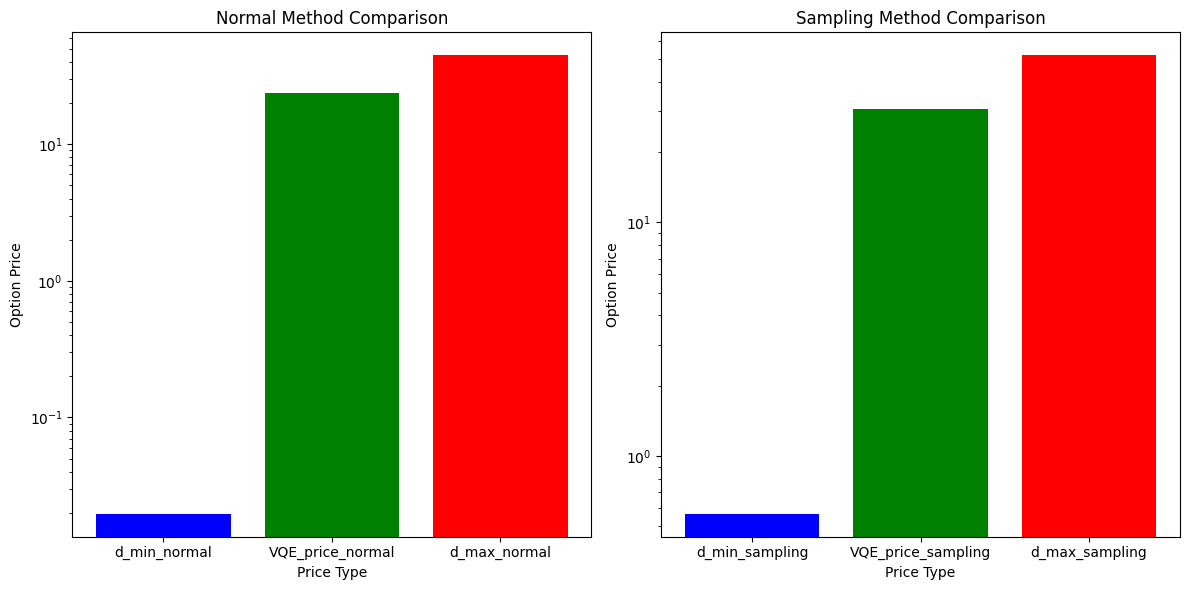

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot for normal method
plt.subplot(1, 2, 1)
plt.bar(['d_min_normal', 'VQE_price_normal', 'd_max_normal'], [d_min_normal, VQE_price_normal, d_max_normal], color=['blue', 'green', 'red'])
plt.title('Normal Method Comparison')
plt.xlabel('Price Type')
plt.ylabel('Option Price')
plt.yscale('log')  # Set log scale if values span a large range

# Plot for sampling method
plt.subplot(1, 2, 2)
plt.bar(['d_min_sampling', 'VQE_price_sampling', 'd_max_sampling'], [d_min_sampling, VQE_price_sampling, d_max_sampling], color=['blue', 'green', 'red'])
plt.title('Sampling Method Comparison')
plt.xlabel('Price Type')
plt.ylabel('Option Price')
plt.yscale('log')  # Set log scale if values span a large range

plt.tight_layout()
plt.show()

In [ ]:
# OK 

# Number of shots for a precision epsilon !

In [ ]:
from lib.precision_estimation import *

exact_expectation = expectation_exact_value(S,Pi,ansatz=variational_circuit) 
print(exact_expectation)


sampled_expectation = expectation_sampled_value(S,Pi,ansatz=variational_circuit, shots=1000)
print(sampled_expectation)

0.512888458796584
0.5553259538547186


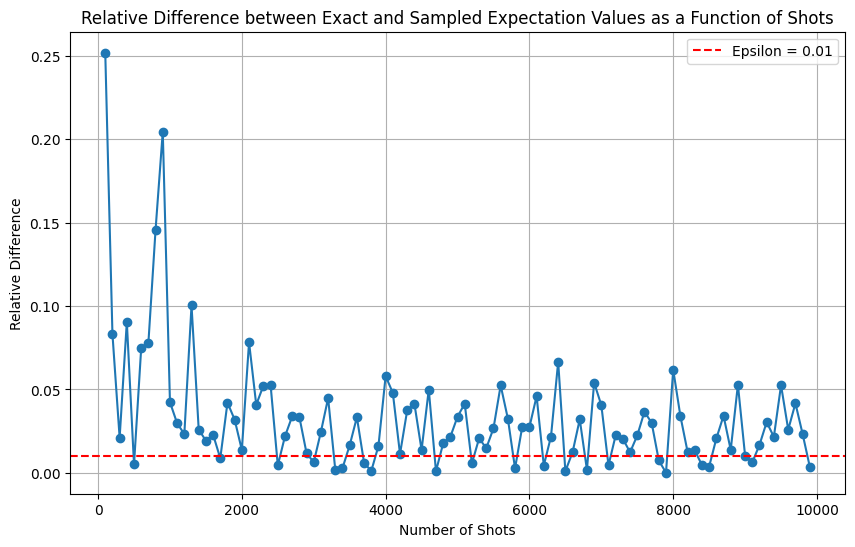

In [ ]:
def plot_expectation_difference(shot_values,epsilon) : 
    exact_expectation = expectation_exact_value(S, Pi, ansatz=variational_circuit)
    
    differences = []
    for shots in shot_values:
        sampled_expectation = expectation_sampled_value(S, Pi, ansatz=variational_circuit, shots=shots)
        difference = np.abs((exact_expectation - sampled_expectation)/exact_expectation)
        differences.append(difference)
    
    plt.figure(figsize=(10, 6))
    plt.plot(shot_values, differences, marker='o')
    plt.axhline(y=epsilon, color='r', linestyle='--', label=f'Epsilon = {epsilon}')
    plt.xlabel('Number of Shots')
    plt.ylabel('Relative Difference')
    plt.title('Relative Difference between Exact and Sampled Expectation Values as a Function of Shots')
    plt.legend()
    plt.grid(True)
    plt.show()

shot_values = np.arange(100, 10000, 100)  # Example range of shot values
epsilon = 0.01  # Example epsilon value

plot_expectation_difference(shot_values,epsilon)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter1d
# from lib.precision_estimation import expectation_exact_value, expectation_sampled_value

# def find_shots_for_epsilon(S, Pi, variational_circuit, epsilon_values, max_shots=10000, step=100):
#     """
#     Finds the minimum number of shots needed to reach each epsilon threshold.
    
#     Parameters:
#     - S: The payoff matrix
#     - Pi: The initial state vector
#     - variational_circuit: The variational quantum circuit
#     - epsilon_values: List or array of epsilon values to check
#     - max_shots: Maximum number of shots to consider
#     - step: Step size for increasing shots
    
#     Returns:
#     - A dictionary with epsilon values as keys and the corresponding minimum number of shots as values
#     """
#     exact_expectation = expectation_exact_value(S, Pi, ansatz=variational_circuit)
    
#     epsilon_shots = {}
#     for epsilon in epsilon_values:
#         for shots in range(step, max_shots + step, step):
#             sampled_expectation = expectation_sampled_value(S, Pi, ansatz=variational_circuit, shots=shots)
#             relative_difference = np.abs((exact_expectation - sampled_expectation) / exact_expectation)
#             if relative_difference <= epsilon:
#                 epsilon_shots[epsilon] = shots
#                 break
#         else:
#             # If no valid shot count is found within the max_shots limit
#             epsilon_shots[epsilon] = None
    
#     return epsilon_shots

# def plot_shots_for_epsilon(epsilon_shots):
#     """
#     Plots the number of shots needed to reach each epsilon threshold.
    
#     Parameters:
#     - epsilon_shots: Dictionary with epsilon values as keys and the corresponding minimum number of shots as values
#     """
#     epsilon_values = np.array(list(epsilon_shots.keys()))
#     shots_needed = np.array(list(epsilon_shots.values()))

#     # Filter out None values
#     valid_indices = shots_needed != None
#     epsilon_values = epsilon_values[valid_indices]
#     shots_needed = shots_needed[valid_indices]

#     # Smoothing the data
#     shots_smoothed = gaussian_filter1d(shots_needed, sigma=2)

#     plt.figure(figsize=(10, 6))
#     plt.scatter(1/epsilon_values, shots_needed, label='Data Points', color='blue')
#     plt.plot(1/epsilon_values, shots_smoothed, label='Smoothed Trend', color='red')
#     plt.xlabel('1/Epsilon')
#     plt.ylabel('Number of Shots')
#     plt.title('Number of Shots Needed to Reach Threshold Epsilon')
#     plt.yscale('log')  # Log scale for better visualization if necessary
#     plt.xscale('log')
#     plt.grid(True, which="both", ls="--")
#     plt.legend()
#     plt.show()


# epsilon_values = np.linspace(0.0001, 0.1, 1000)  # Example range of epsilon values

# epsilon_shots = find_shots_for_epsilon(S, Pi, variational_circuit, epsilon_values)
# plot_shots_for_epsilon(epsilon_shots)

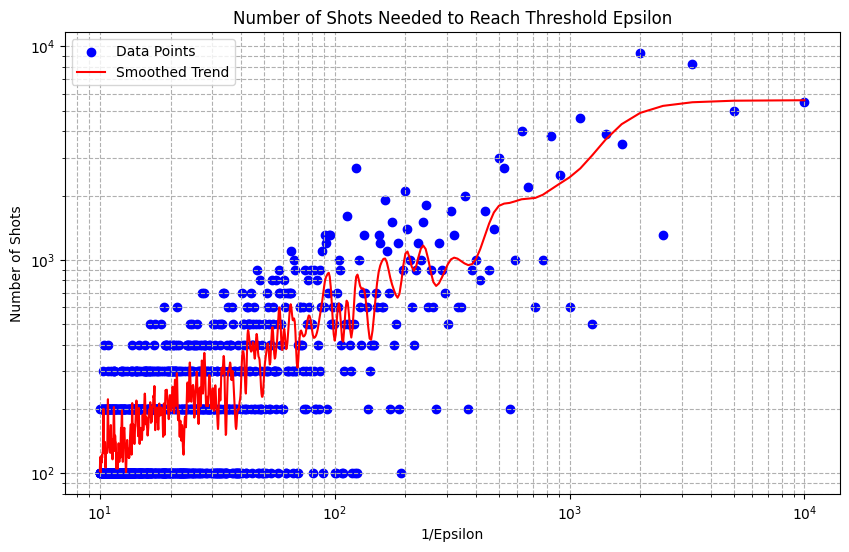